# Demo: Integrating With Kubernetes

## Integrating Workflow Manager with Resource Manager

The idea is to improve the deployment of workflows at scale.

### 1. Relationship between the workflow manager and the resource manager.
    
    AI Workflow Manager -> Scanflow
    
    Resource Manager -> Kubernetes
    

### 2. Static deployment.

    2.1 Steps for Scanflow.

      Setup -> Deployment -> Run -> Checking/Tracking
      
    2.2 Case study.
    

### 3. **Future Work**: 
    2.1 Improve static deployment.
    
    2.2 Dynamic adjustment.

##  1. conceptual model and practical implementation of multi-layer controlled AI Workflow

### (1). A conceptual model of multi-layer controlled AI workflows
    
The idea is to separate the concerns into different layers. The domain-controlled layer deals with the user requirements and problems related with the workflow or business. The infrastructure-controlled layer deals with the external context from the environment and resources within the system.

    - Target System -> AI workflows
    
    - Domain-controlled Layer (Domain Framework)-> AI Workflow Manager
    
    - Infrastructure-controlled Layer -> Resource Manager
    
    
### (2). Trend of AI workflows.   **Containerized**


### (3). A practical implementation of multi-layer controlled AI workflows

For AI workflows, the Domain Framework we choose our AI Workflow Manager(Scanflow) which supports AI workflows to be packaged into containers and provides tracker and health checker. The Resource Manager we choose Kubernetes.


    - AI Workflow Manager -> Scanflow (Step up workflow as containers)
    
    - Resource Maneger -> Kubernetes (container orchstration)

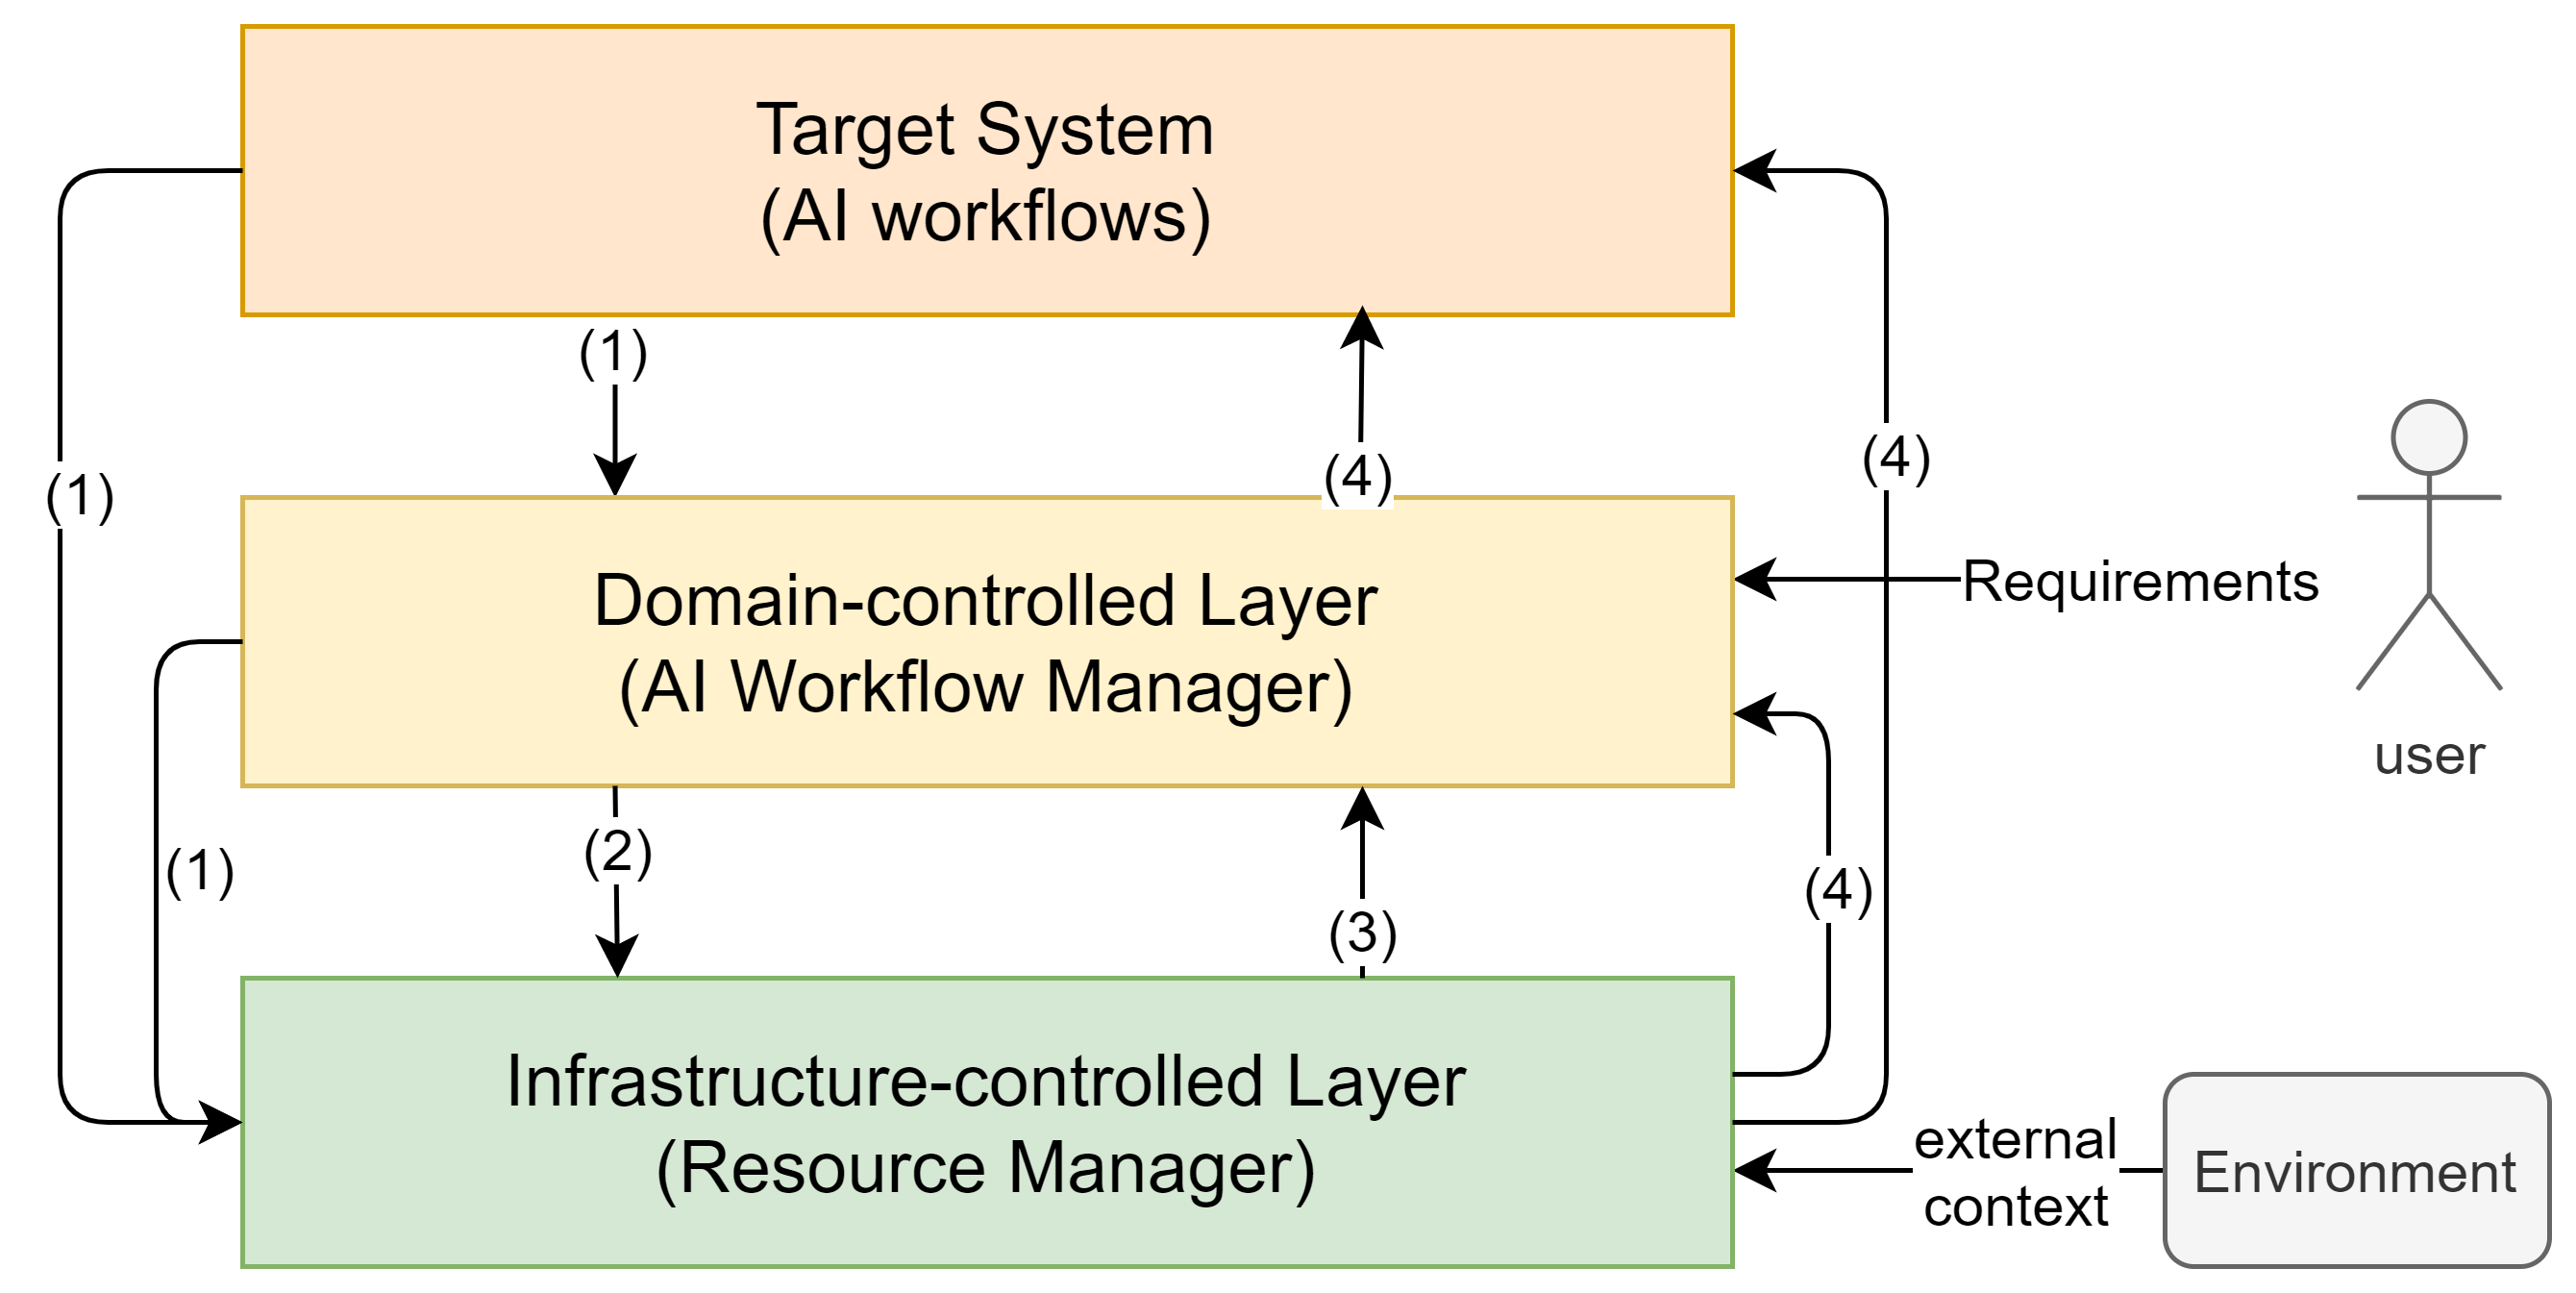

In [1]:
from IPython.display import Image
Image("picture/conceptual model.png", width=600, height=600)

A Service in Kubernetes is an abstraction which defines a logical set of Pods and a policy by which to access them.

A job in Kubernetes is a supervisor for pods carrying out batch processes, that is, a process that runs for a certain time to completion, for example a calculation or a backup operation.

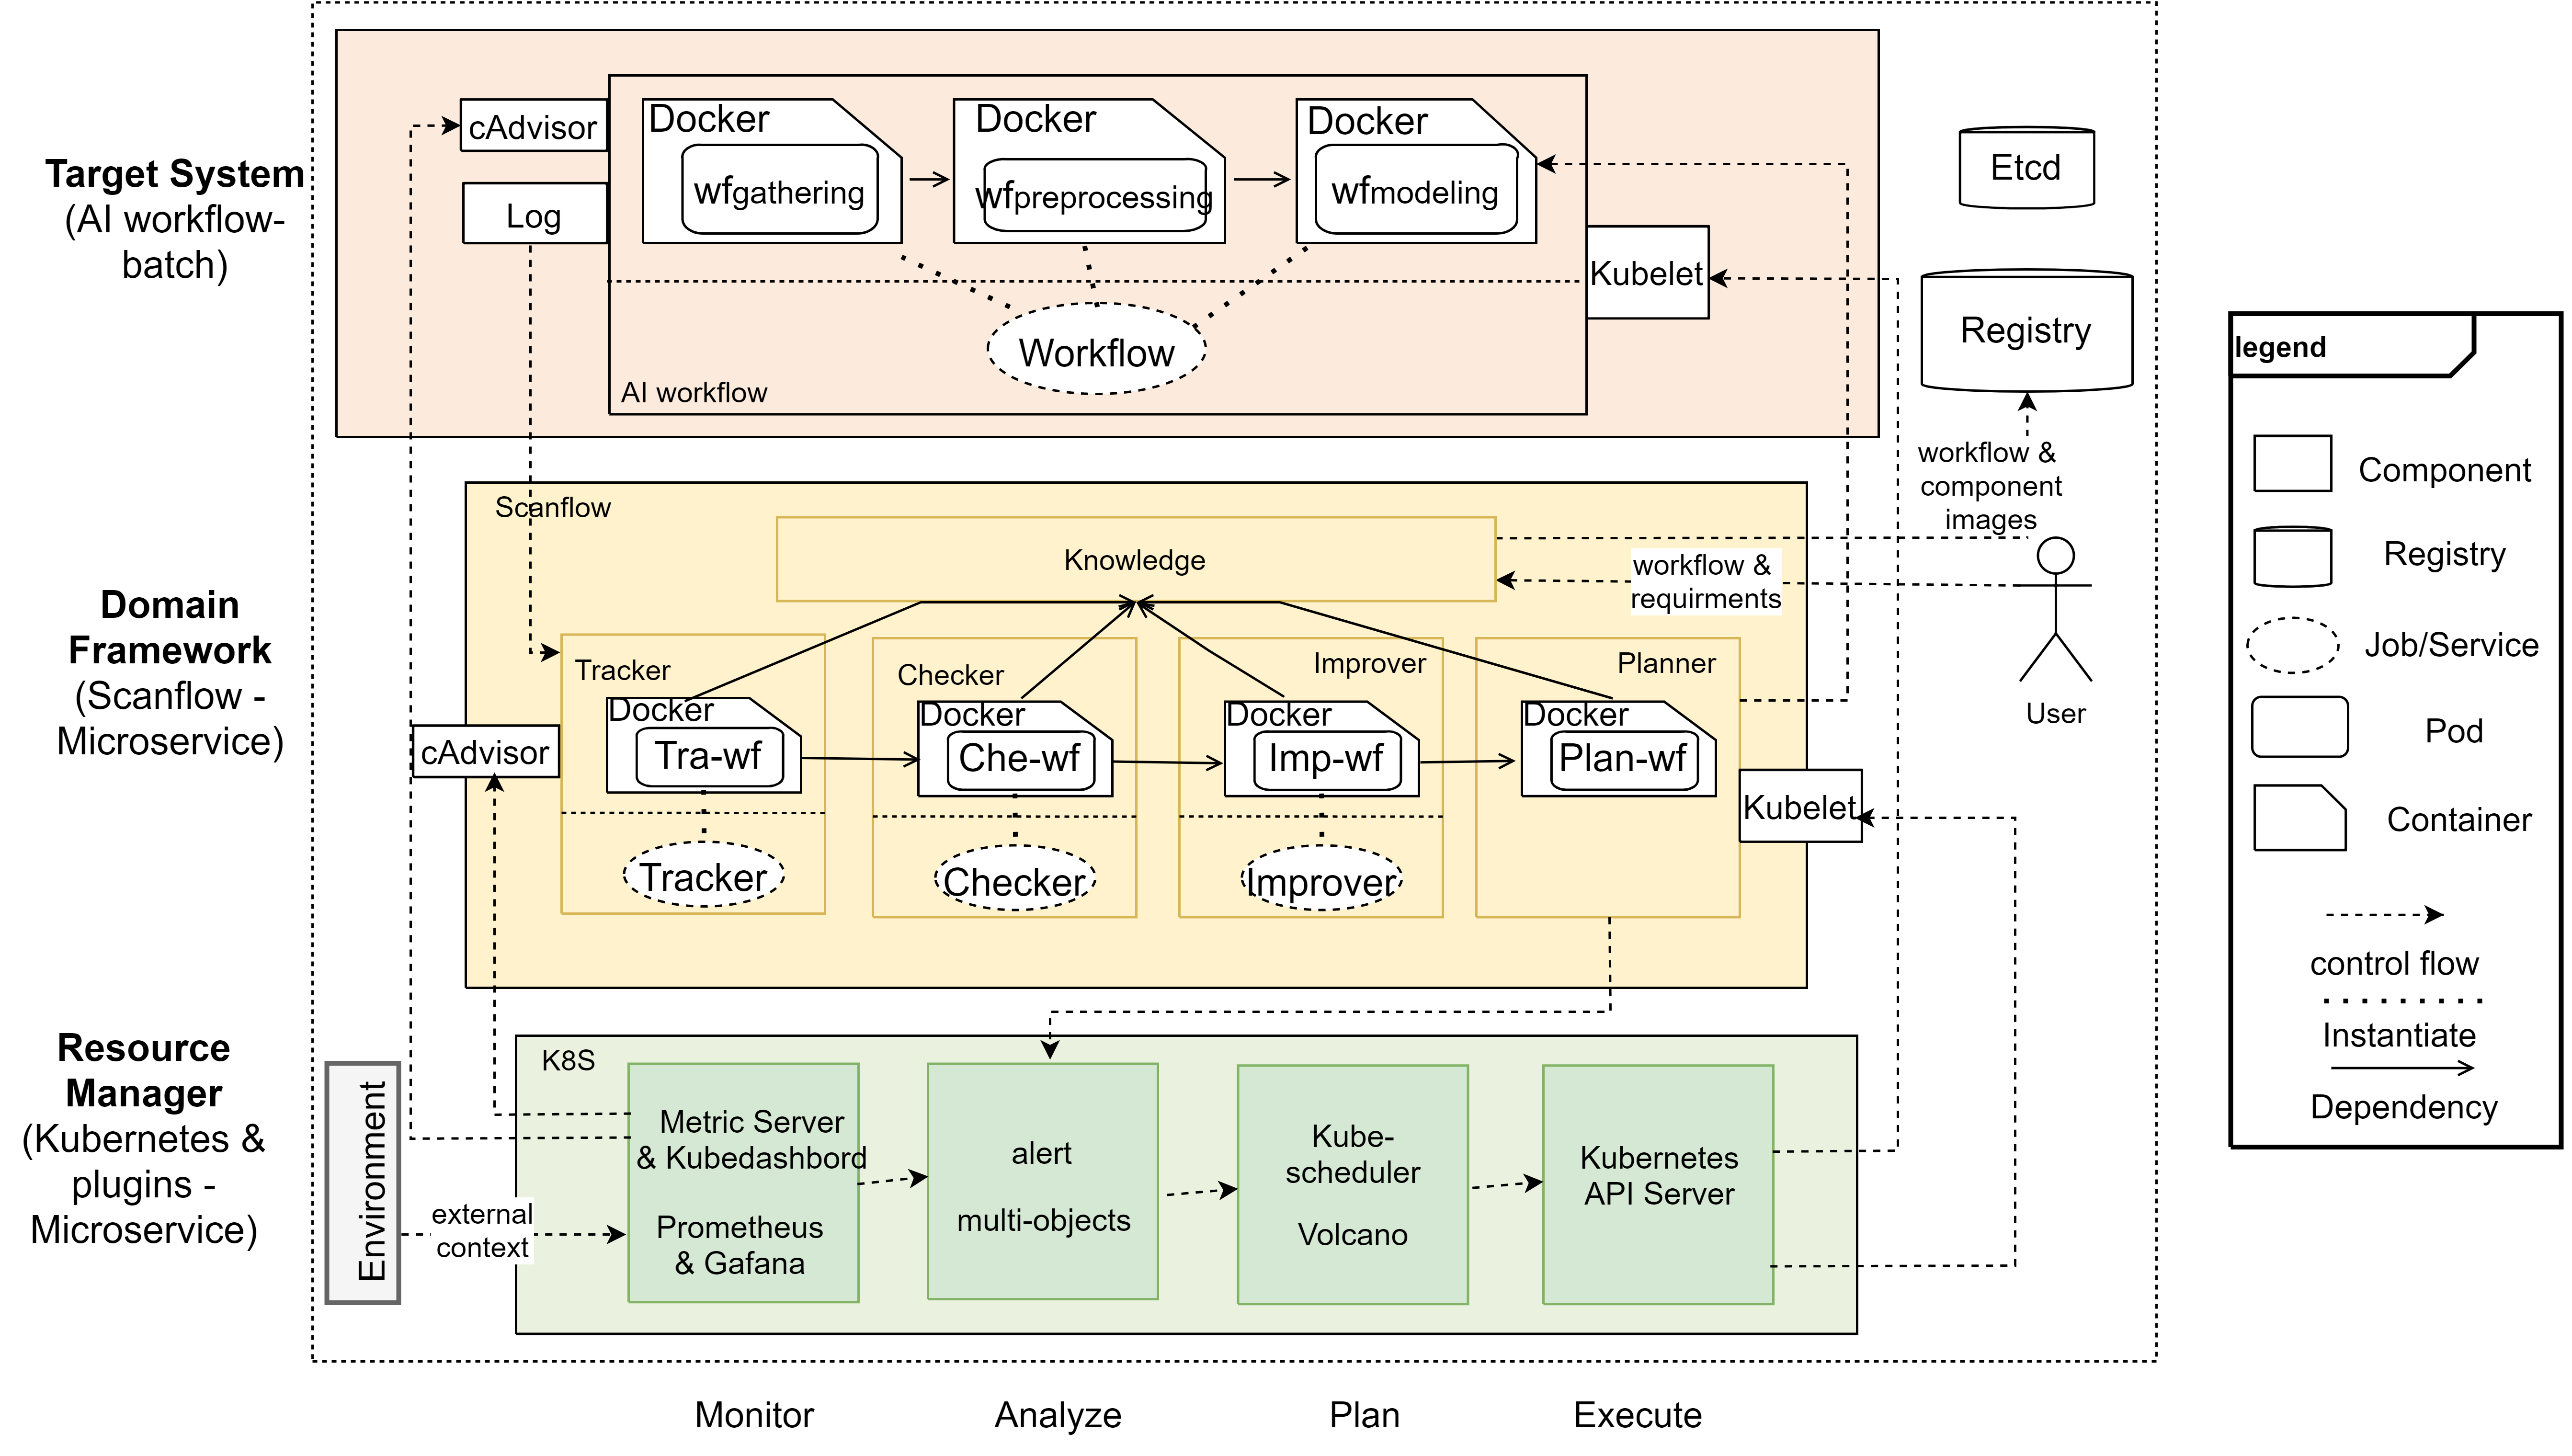

In [4]:
from IPython.display import Image
Image("picture/practical model.png", width=1000, height=2000)

##  2. Static deployment
###  (1) Steps for scanflow

Setup -> **Deployment(workflow)** -> Run -> Checking/Tracking **Deploy scanflow components**

   - HELP scanflow deploying workflow at scale
   
   - HELP scanflow starting components to control workflow

### (2) Case study

1. Build the workflows (build images)
2. Start the worklfows (start containers through **kubernetes**)
3. Run the workflows (find container through **kubernetes**, execute the python files inside containers within **pod**)

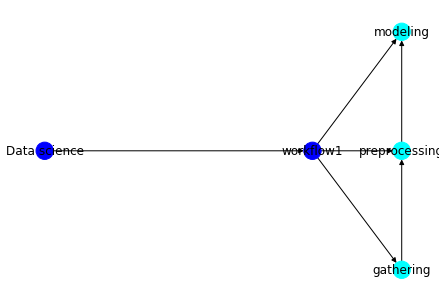

In [14]:
workflower.draw_workflow('Data science')

In [6]:
import sys
sys.path.insert(0,'..')

### Step1: Build workflow

In [7]:
%%time

from scanflow.setup import Setup, Executor, Tracker, Workflow
from scanflow.deploy import Deploy

# App folder
app_dir = '/gpfs/bsc_home/xpliu/scanflow/kubernetes/demo3/data-science/'

# Workflows

executors = [Executor(name='gathering', 
                       file='gathering.py',
                       parameters={'raw_dataset': 'leaf.csv'},
                       dockerfile='Dockerfile_gathering'),
              Executor(name='preprocessing', 
                       file='preprocessing.py',
                       parameters={'training': 'training.csv',
                                   'testing': 'testing.csv'},
                       requirements='req_preprocessing.txt'),
              
              Executor(name='modeling', 
                      file='modeling.py',
                      parameters={'training': ['X_train.csv', 'y_train.csv'],
                                  'testing': ['X_test.csv', 'y_test.csv'],
                                  'model_path': 'models',
                                  'n_estimators': 3},
                      requirements='req_modeling.txt')
              ]

workflow1 = Workflow(name='workflow1', 
                     executors=executors,
                     tracker=Tracker(port=8001))


workflower = Setup(app_dir, workflows=[workflow1],
                             verbose=False)

# Build the nodes
workflower.build_workflows()

CPU times: user 3.49 s, sys: 6.07 s, total: 9.56 s
Wall time: 1.92 s


### Step2: Start the worklfows (start containers through **kubernetes**)

In [8]:
# Start containers 
deployer = Deploy(app_dir, workflower, verbose=True)

deployer.start_workflows_k8s()

  0%|          | 0/1 [00:00<?, ?it/s]06-Jan-21 11:47:58 -  INFO - [++] Starting workflow: [workflow1].
06-Jan-21 11:47:58 -  INFO - Deployment created. status='tracker-workflow1'
06-Jan-21 11:47:58 -  INFO - [+] Starting pods: [workflow1:gathering].
06-Jan-21 11:47:58 -  INFO - Deployment created. status='gathering'
06-Jan-21 11:47:58 -  INFO - [+] Starting pods: [workflow1:preprocessing].
06-Jan-21 11:47:58 -  INFO - Deployment created. status='preprocessing'
06-Jan-21 11:47:58 -  INFO - [+] Starting pods: [workflow1:modeling].
06-Jan-21 11:47:58 -  INFO - Deployment created. status='modeling'
06-Jan-21 11:47:58 -  INFO - [+] Workflow: [workflow1] was started successfully.
100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


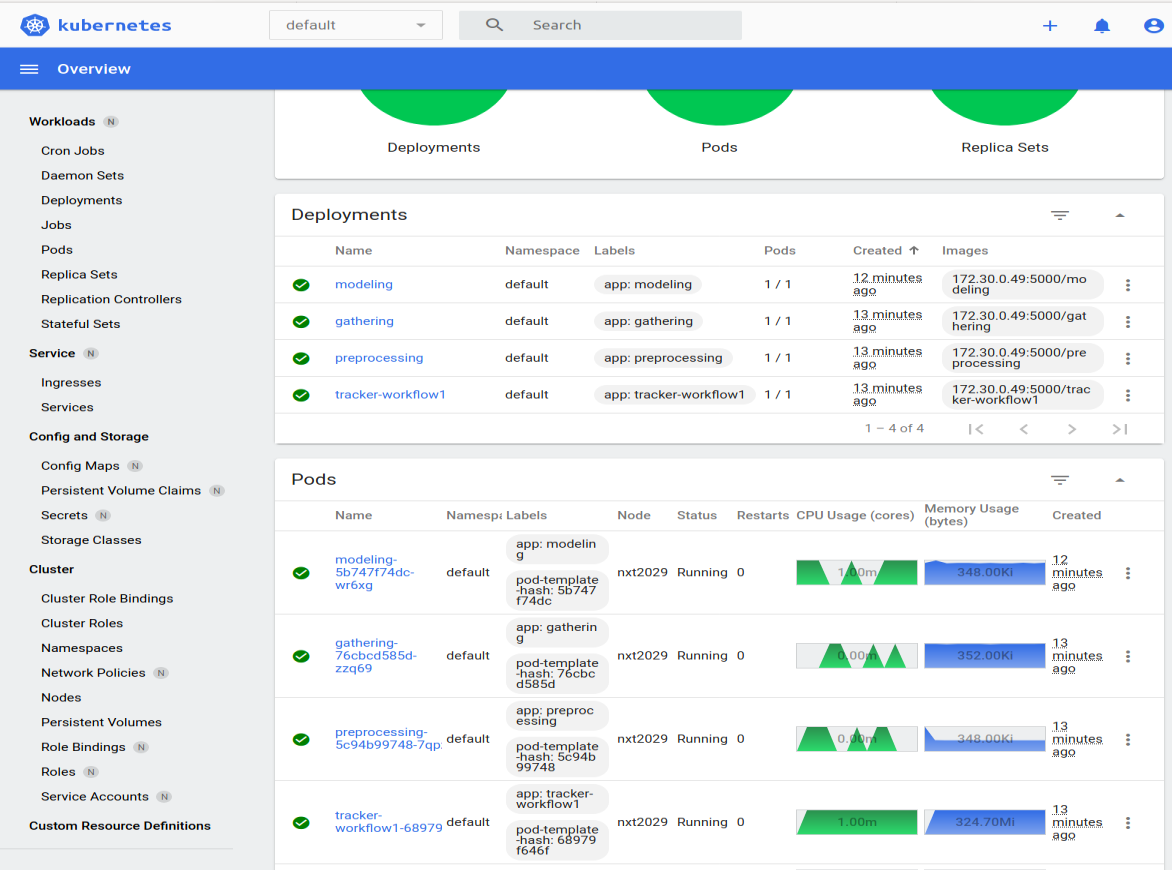

In [9]:
from IPython.display import Image
Image("picture/start.PNG", width=1000, height=3000)

In [11]:
apiVersion: apps/v1
kind: Deployment
metadata:
  labels:
    app: gathering
  name: gathering
spec:
  replicas: 1
  selector:
    matchLabels:
      app: gathering
  template:
    metadata:
      labels:
        app: gathering
    spec:
      containers:
        image: 172.30.0.49:5000/gathering
        imagePullPolicy: IfNotPresent
        command: [ "/bin/bash", "-c", "--" ]
        args: [ "while true; do sleep 30; done;" ]
        name: gathering
        volumeMounts:
          - mountPath: /app
            name: gathering-hostpath0
          - mountPath: /mlflow
            name: gathering-hostpath1
      restartPolicy: Always
      volumes:
      - hostPath:
          path: /gpfs/bsc_home/xpliu/scanflow/kubernetes/demo3/data-science
        name: gathering-hostpath0
      - hostPath:
          path: /gpfs/bsc_home/xpliu/scanflow/kubernetes/demo3/data-science/ad-stuff/ad-tracker/tracker-workflow1
        name: gathering-hostpath1

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 32)

### Step 3: Run the workflows (find container through **kubernetes**, execute the python files inside containers within **pod**)

In [13]:
# Run workflows
deployer = Deploy(app_dir, workflower, verbose=True)

deployer.run_workflows_k8s()

  0%|          | 0/1 [00:00<?, ?it/s]06-Jan-21 11:48:16 -  INFO - [++] Running workflow: [workflow1].
06-Jan-21 11:48:16 -  INFO - [+] Workflow: [workflow1] was run in parallel.
06-Jan-21 11:48:16 -  INFO - [+] Running env: [workflow1:gathering].
06-Jan-21 11:48:16 -  INFO - gathering-76cbcd585d-m484r


Running command... cd /app/workflow

Running command... pwd

STDOUT: /app/workflow

Running command... export MLFLOW_TRACKING_URI=http://10.244.71.108:8001

Running command... python gathering.py --raw_dataset leaf.csv



06-Jan-21 11:48:19 -  INFO - [+] Running (gathering.py). 
06-Jan-21 11:48:19 -  INFO - [+] Environment [workflow1:gathering] finished successfully. 
06-Jan-21 11:48:19 -  INFO - [+] Running env: [workflow1:preprocessing].
06-Jan-21 11:48:19 -  INFO - preprocessing-5c94b99748-2tn5c


Running command... cd /app/workflow

Running command... pwd

STDOUT: /app/workflow

Running command... export MLFLOW_TRACKING_URI=http://10.244.71.108:8001

Running command... python preprocessing.py --training training.csv --testing testing.csv



06-Jan-21 11:48:22 -  INFO - [+] Running (preprocessing.py). 
06-Jan-21 11:48:22 -  INFO - [+] Environment [workflow1:preprocessing] finished successfully. 
06-Jan-21 11:48:22 -  INFO - [+] Running env: [workflow1:modeling].
06-Jan-21 11:48:22 -  INFO - modeling-5b747f74dc-j5jfh


Running command... cd /app/workflow

Running command... pwd

STDOUT: /app/workflow

Running command... export MLFLOW_TRACKING_URI=http://10.244.71.108:8001

Running command... python modeling.py --training X_train.csv y_train.csv --testing X_test.csv y_test.csv --model_path models --n_estimators 3



06-Jan-21 11:48:25 -  INFO - [+] Running (modeling.py). 
06-Jan-21 11:48:25 -  INFO - [+] Environment [workflow1:modeling] finished successfully. 
06-Jan-21 11:48:25 -  INFO - [+] Workflow: [workflow1] was run successfully.
100%|██████████| 1/1 [00:09<00:00,  9.22s/it]

Elapsed time: 9.218701839447021


## 3. Futher Steps

1. Consider workflows as batch jobs and scanflow as services

2. Use native batch scheduler to deploy the containers

3. Define custom operators
    
     - Custom Resource Definitions(CRD)
    
     - controller to watch and act on the CRD

4. Add privilege control configuration and persistent volume